<a href="https://colab.research.google.com/github/dojian/classML/blob/main/03_Linear_Regression_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

This lab continues our study of linear regression. You'll train your first models with Tensorflow, using a real dataset to predict car prices from their features. Note that Tensorflow is a rapidly changing library. This means you'll often see warnings about deprecations. You can ignore the warnings in our labs.

In [26]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import tensorflow as tf

## Understanding the data
Below, we'll train models using some real data. Here we'll use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile)  from 1985 Ward's Automotive Yearbook that is part of the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets).

But before doing any training (or evaluating), let's make sure we understand what we're working with.

### Load the data
Load the data using the column names from [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile). We'll only use a few of the columns so don't worry about understanding what they all mean.

In [27]:
# Provide the names for the feature columns since the CSV file with the data
# does not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# Load the data from a CSV file into a pandas dataframe. Remember that each row
# is an example and each column in a feature.
car_data = pd.read_csv(
    'https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
    sep=',', names=cols, header=None, encoding='latin-1')

# Display applies built-in formatting for nicer printing, if available.
display(car_data)

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


### Randomize
Since we'll be using SGD (Stochastic Gradient Descent) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. Note that the original data (above) appears sorted by *make* in alphabetic order.

In [28]:
# We want to shuffle the order of the rows without touching the columns.
# First, we get a list of indices corresponding to the rows.
indices = np.arange(car_data.shape[0])
print('indices:', indices, '\n')

# Next, we shuffle the indices using np.random.permutation but set a random seed
# so that everyone gets the same results each time.
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Finally, we use dataframe.reindex to change the ordering of the original
# dataframe.
car_data = car_data.reindex(shuffled_indices)
display(car_data)

# Note that this could be done in one fancy line:
# car_data = car_data.reindex(np.random.permutation(car_data.shape[0]))

indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204] 

shuffled indices: [ 52 181   5  18 188 170  76 154 104  33  12 129  55  66  45 169 130   7
  37 152  80 111 131 171 179 138 156 113 161  89 183 193 125 173 

,symboling,losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
52,1,104,mazda,gas,std,two,hatchback,fwd,front,93.1,...,91,2bbl,3.03,3.15,9.0,68,5000,31,38,6795
181,-1,?,toyota,gas,std,four,wagon,rwd,front,104.5,...,161,mpfi,3.27,3.35,9.2,156,5200,19,24,15750
5,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
18,2,121,chevrolet,gas,std,two,hatchback,fwd,front,88.4,...,61,2bbl,2.91,3.03,9.5,48,5100,47,53,5151
188,2,94,volkswagen,gas,std,four,sedan,fwd,front,97.3,...,109,mpfi,3.19,3.40,10.0,100,5500,26,32,9995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-1,93,mercedes-benz,diesel,turbo,four,sedan,rwd,front,110.0,...,183,idi,3.58,3.64,21.5,123,4350,22,25,25552
192,0,?,volkswagen,diesel,turbo,four,sedan,fwd,front,100.4,...,97,idi,3.01,3.40,23.0,68,4500,33,38,13845
117,0,161,peugot,gas,turbo,four,sedan,rwd,front,108.0,...,134,mpfi,3.61,3.21,7.0,142,5600,18,24,18150
47,0,145,jaguar,gas,std,four,sedan,rwd,front,113.0,...,258,mpfi,3.63,4.17,8.1,176,4750,15,19,32250


### Feature selection
To keep things simple, we will keep just a few of the 26 columns. Since the values come as strings, we need to convert them to floats. Also, we remove examples (rows) that have some missing value(s) of the columns we care about. Note that in general, there are various ways to deal with missing features, and this strategy of dropping examples with any missing feature is not ideal.

In [29]:
# Choose a subset of columns (these are all numeric).
columns = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
car_data = car_data[columns]

# Convert strings to numeric values, coercing missing values to nan.
for column in columns:
  car_data[column] = pd.to_numeric(car_data[column], errors='coerce')

# The dropna function drops rows with missing value(s) by default.
car_data = car_data.dropna()

# This leaves us with 199 examples.
display(car_data)

<ipython-input-29-47b7391d56ed>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_data[column] = pd.to_numeric(car_data[column], errors='coerce')


,horsepower,peak-rpm,city-mpg,highway-mpg,price
52,68.0,5000.0,31,38,6795.0
181,156.0,5200.0,19,24,15750.0
5,110.0,5500.0,19,25,15250.0
18,48.0,5100.0,47,53,5151.0
188,100.0,5500.0,26,32,9995.0
...,...,...,...,...,...
67,123.0,4350.0,22,25,25552.0
192,68.0,4500.0,33,38,13845.0
117,142.0,5600.0,18,24,18150.0
47,176.0,4750.0,15,19,32250.0


### Train/Test split
Now that we've shuffled the order, we can split into portions for train and test easily. We'll try to avoid looking at the test data.

We're going to train models that **predict price from the other columns**, so we'll create separate variables for input and output data.


In [30]:
# We'll use these input features.
features = ['horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

# Use a ~80/20 train/test split.
car_train = car_data[:160]
car_test = car_data[160:]

# Create separate variables for features (inputs) and labels (outputs).
# We will be using these in the cells below.
car_train_features = car_train[features]
car_test_features = car_test[features]
car_train_labels = car_train['price']
car_test_labels = car_test['price']

# Confirm the data shapes are as expected.
print('train data shape:', car_train_features.shape)
print('train labels shape:', car_train_labels.shape)
print('test data shape:', car_test_features.shape)
print('test labels shape:', car_test_labels.shape)

train data shape: (160, 4)
train labels shape: (160,)
test data shape: (39, 4)
test labels shape: (39,)


---
### Exercise 1: Baseline (20 points)

Now that we have test data, we can evaluate a baseline. We'll use the average price of cars in the training set as our baseline model -- that is, the baseline always predicts the average price regardless of the input. And, instead of MSE, let's use **RMSE** (root mean squared error) -- that is, just take the square root of the MSE -- as our evaluation metric. <span style="color:chocolate"> Print out the following: </span>

1. Implement this baseline.
2. Compute the RMSE of the baseline on the train data.
3. Compute the RMSE of the baseline on the test data.
3. Is the test RMSE larger or smaller than the train RMSE? Explain whether this is what you'd expect.

In [31]:
#Implement this baseline
baseline_pred = np.average(car_train_labels)

#Compute the RMSE of the baseline on the train data
diff_tr = car_train_labels - baseline_pred
rmse_tr = np.sqrt(np.mean(diff_tr**2))

#Compute the RMSE of the baseline on the test data
diff_te = car_test_labels - baseline_pred
rmse_te = np.sqrt(np.mean(diff_te**2))

print('the baseline as the average price of cars in the training set is', baseline_pred)
print('the RMSE of the baseline on the train data is',rmse_tr)
print('the RMSE of the baseline on the test data is', rmse_te)

the baseline as the average price of cars in the training set is 13064.675
the RMSE of the baseline on the train data is 7946.598808255957
the RMSE of the baseline on the test data is 8018.000777288523


*Written answer: The test RMSE is larger than the train RMSE. This is what I expected as the baseline predictor is the average of the trained data. And the RMSE will be larger when check against the test data*

---

### Feature histograms
It's hard to stare at a matrix of 160x5 numbers (the shape of our training data) and know what to make of it. Plotting feature histograms is a good way to start building intuition about the data. This gives us a sense of the distribution of each feature, but not how the features relate to each other.

We can also use the `describe` function to look at some aggregate statistics for the `DataFrame`.

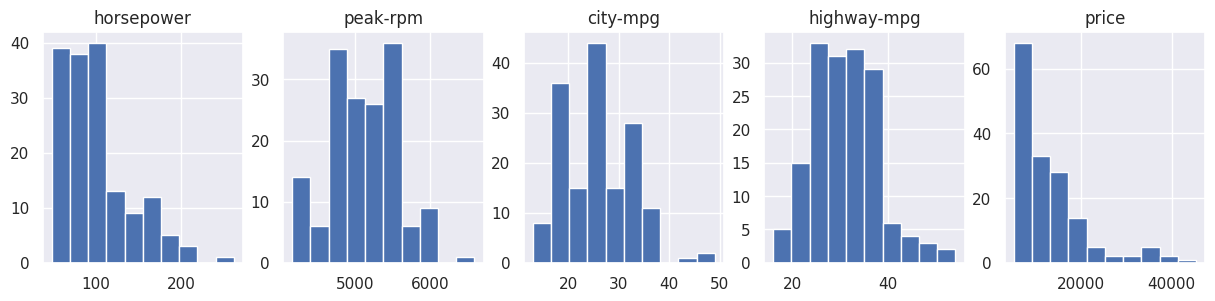

,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,160.000000,160.000000,160.000000,160.000000,160.000000
mean,101.468750,5105.625000,25.493750,31.025000,13064.675000
std,38.227542,467.059162,6.649346,7.106512,7971.548944
min,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,70.000000,4800.000000,19.000000,25.000000,7609.000000
50%,93.000000,5100.000000,25.000000,30.500000,10320.000000
75%,115.250000,5500.000000,31.000000,37.000000,16500.000000
max,262.000000,6600.000000,49.000000,54.000000,45400.000000


In [32]:
plt.figure(figsize=(15, 3))
for i in range(len(columns)):
  plt.subplot(1, 5, i+1)
  plt.hist(np.array(car_train[columns[i]]))
  plt.title(columns[i])
plt.show()

display(car_train.describe())

---
### Exercise 2: Feature correlations (20 points)

Using pandas [`corr()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) to print all the pairwise correlation coefficients for the columns (use the training data only). See also the [Wikipedia page on correlation](https://en.wikipedia.org/wiki/Correlation) for more background.

Then answer the following questions:

1. It appears that higher-priced cars have higher or lower fuel efficiency?
1. Which two features are likely to be most redundant?
1. Which feature is likely to be least useful for predicting price?

Extra (ungraded): try using [`sns.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to examine each pair of features.

In [33]:
#print all the pairwise correlation coefficients for the columns
car_train.corr()

,horsepower,peak-rpm,city-mpg,highway-mpg,price
horsepower,1.000000,0.104330,-0.815571,-0.798128,0.829328
peak-rpm,0.104330,1.000000,-0.140634,-0.084458,-0.082567
city-mpg,-0.815571,-0.140634,1.000000,0.973606,-0.695344
highway-mpg,-0.798128,-0.084458,0.973606,1.000000,-0.703647
price,0.829328,-0.082567,-0.695344,-0.703647,1.000000


*Written answer:*

1. It seems that the higher-priced cars have lower fuel efficiency as the correlation between the price and city-mpg/highway-mpg are negative.  
2. City-mpg and highway-mpg seem redundant as both are mpg and has similar correlation at approximately -0.8.
3. It seems peak-rpm is least useful for predicting price as the absolute of the correlation is smallest.

---

## Tensorflow

Let's train a linear regression model much like we did in the previous assignment, but this time using Tensorflow. Tensorflow is a powerful library with a complicated API so it is easy to get overwhelmed. We'll try to keep it simple.

### Build a model
Here's how you use Tensorflow: First, you build a *computational graph*, and then you send data through it.

This is confusing, but you'll get used to it. The computational graph for linear regression is very simple. There are many ways to build graphs, but the [Keras library](https://www.tensorflow.org/api_docs/python/tf/keras) is recommended. Here, we're using [`keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) to create a model layer. We will go over Tensorflow and Keras in more detail, so don't worry about understanding everything now.

In [34]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model

After we've built a model, we can inspect the initial parameters (weights). There should be two ($w_0$ and $b$) and they should be initialized to 1, which we specified above using `tf.ones_initializer`. Unlike our code in the last assignment, Tensorflow stores the bias/intercept separately from the other weights/parameters for the layer. We also don't need to prepend a column of 1s to learn the bias -- Tensorflow handles this for us.

In [35]:
# Build a model.
model = build_model(num_features=1, learning_rate=0.0001)

# Use get_weights() which returns lists of weights and biases for the layer.
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]]
Biases: [1.]


Let's also try building a model with 2 features. Notice that in both cases, the weights are 2-D while the biases are 1-D.

In [36]:
# Build a model and look at the initial parameter values.
model = build_model(num_features=2, learning_rate=0.0001)
weights, biases = model.layers[0].get_weights()
print('Weights:', weights)
print('Biases:', biases)

Weights: [[1.]
 [1.]]
Biases: [1.]


### Making predictions
Wait, we haven't trained yet! Why are we talking about making predictions? Well, remember that a model is a computational graph. That means we can pass data (of the expected shape) through the model (using the current values of the parameters) to make predictions.

Before training, the parameters are set to their initial values (1s in our case). During training, we use the current predictions to compute a gradient and update the parameter values. Making predictions using the model without updating parameter values is called **Inference**.

In the example code below, make sure you understand the output of `predict`.

In [37]:
# Build a model that expects 1 input feature.
model = build_model(num_features=1, learning_rate=0.0001)

# Make a prediction for a single input.
print(model.predict([42]))

# Make predictions for 2 inputs.
print(model.predict([42, 99]))

1/1 [==============================] - 0s 55ms/step
[[43.]]
1/1 [==============================] - 0s 45ms/step
[[ 43.]
 [100.]]


### Train a model
Now let's actually train a model, initially with just 1 feature -- the horsepower. Notice that the `fit` function can take pandas DataFrame objects for input (x) and output (y). In addition, we can convert the return value into a DataFrame that tracks training metrics (in this case, training data loss and validation data loss) after each *epoch* (a full pass through the training data).

Remember that we're using SGD, which is actually mini-batch SGD. That is, each time the model estimates the loss for the current weights, it randomly samples a batch of training examples (of the specified size) to do so.

Finally, we'll reserve some more examples (taken out of the training set) as a *validation set*. We use this data to check for overfitting while training. Why not use the *test set* for this purpose? We want to maintain the purity of the test set so we try to only use it at the end of the experimental process.

In [38]:
model = build_model(num_features=1, learning_rate=0.0001)

history = model.fit(
  x = car_train_features[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=5,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
history = pd.DataFrame(history.history)
display(history)

,loss,val_loss
0,9.451231e+08,2.757706e+09
1,1.157147e+10,2.634769e+10
2,8.129325e+10,3.772780e+11
3,1.176509e+12,3.559103e+12
4,5.976473e+12,3.931725e+13


### Feature scaling
The loss is increasing as we train! What's going wrong?

Look back at the histograms above. Notice that the scale of each feature value is different. Horsepower ranges from 48 to 262, while price ranges from \$5118 to \$45400. These different scales makes it more difficult to set the learning rate, and may make learning nearly impossible when we use multiple features (the scales of the gradients will overwhelm the actual feature importances).

First, try reducing the learning rate above by 10x to 1e-5. That should fix the problem for now.

But a better solution is to normalize the features so they are all roughly in the same range. We'll do this with mean and variance normalization. That is, for each feature, we subtract the mean (center the distribution on 0) and divide by the standard deviation (set the variance to 1).

---
### Exercise 3: Feature normalization (20 points)

Apply mean and variance normalization to produce car_train_features_norm and car_test_features_norm. These should be copies of the car_train_features and car_test_features, but with normalized feature values. Note that we're not normalizing the labels (prices).

* DataFrame objects have `mean` and `std` functions you can use.
* **Important:** You can't normalize the test data by computing mean and variance on the test data, as this would violate our willful blindness of the test data.
* Use the `describe` function (as above) to verify your normalized data looks right.

In [39]:
#Compute mean and std for each feature in the training data
feature_means = car_train_features.mean()
feature_stds = car_train_features.std()

#Normalize the training features
car_train_features_norm = (car_train_features - feature_means) / feature_stds

#Normalize the test features using mean and std from the training data
car_test_features_norm = (car_test_features - feature_means) / feature_stds

#Use the describe function (as above) to verify
print(car_train_features_norm.describe())
print(car_test_features_norm.describe())

       horsepower    peak-rpm      city-mpg   highway-mpg
count  160.000000  160.000000  1.600000e+02  1.600000e+02
mean     0.000000    0.000000  2.053913e-16  2.109424e-16
std      1.000000    1.000000  1.000000e+00  1.000000e+00
min     -1.398697   -2.046047 -1.878944e+00 -2.114258e+00
25%     -0.823196   -0.654360 -9.765999e-01 -8.478139e-01
50%     -0.221535   -0.012043 -7.425543e-02 -7.387590e-02
75%      0.360506    0.844379  8.280890e-01  8.407781e-01
max      4.199361    3.199541  3.535122e+00  3.232950e+00
       horsepower   peak-rpm   city-mpg  highway-mpg
count   39.000000  39.000000  39.000000    39.000000
mean     0.257378   0.130694  -0.224646    -0.245261
std      0.888604   1.147576   0.824446     0.778770
min     -1.084787  -1.938994  -1.578163    -1.832826
25%     -0.456968  -0.654360  -0.976600    -0.847814
50%      0.327807   0.202062  -0.224646    -0.144234
75%      0.720194   0.844379   0.226526     0.207556
max      2.760608   3.199541   1.880824     1.544358


---

### Training with features
We're ready to run some experiments with different sets of input features. To start, here's a simple function that plots train and validation set loss.

In [40]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())
  print('Final validation loss:', list(history['val_loss'])[-1])

---
### Exercise 4: Adjusting learning rate (20 points)

Retrain the model predicting price from horsepower, but now using your normalized features. Report validation loss for learning rates [0.0001, 0.001, 0.01, 0.1, 1] after 150 epochs of training. Which produces the best validation loss? [Note: the function is currently only outputting training loss.]

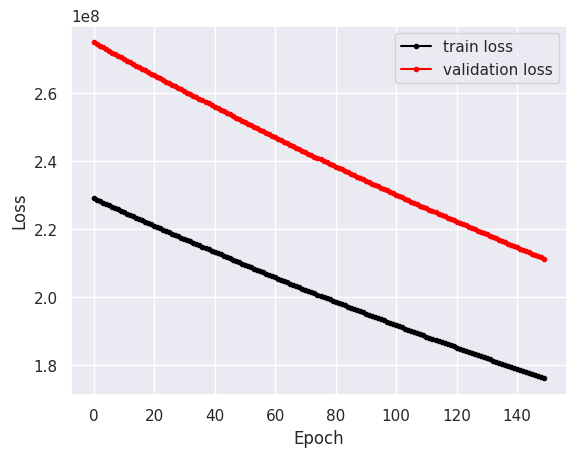

Final train loss: 176059392.0
Final weights: [array([[840.51404]], dtype=float32), array([1813.1569], dtype=float32)]
Final validation loss: 211286080.0


In [41]:
# EDIT CODE HERE
model = build_model(num_features=1, learning_rate=0.0001)

history = model.fit(
  # use the normalized features prepared above
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

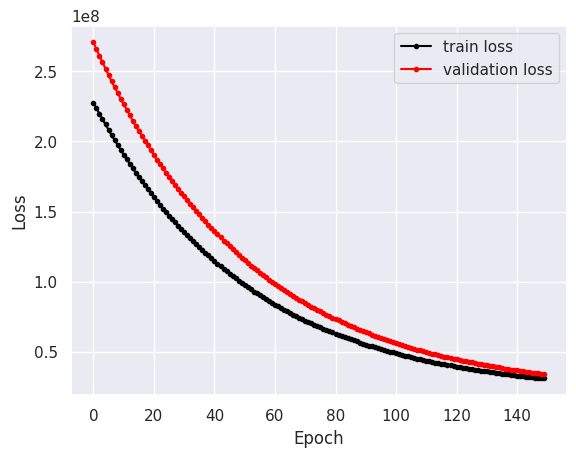

Final train loss: 31046372.0
Final weights: [array([[4899.742]], dtype=float32), array([10132.301], dtype=float32)]
Final validation loss: 34091164.0


In [42]:
# EDIT CODE HERE
model = build_model(num_features=1, learning_rate=0.001)

history = model.fit(
  # use the normalized features prepared above
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

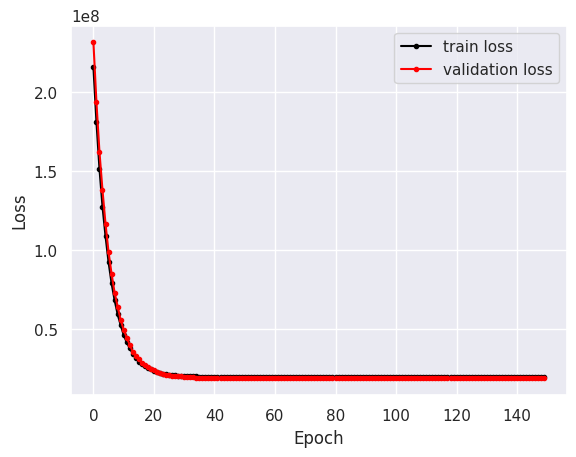

Final train loss: 19829208.0
Final weights: [array([[6535.6763]], dtype=float32), array([13029.8955], dtype=float32)]
Final validation loss: 18954012.0


In [43]:
# EDIT CODE HERE
model = build_model(num_features=1, learning_rate=0.01)

history = model.fit(
  # use the normalized features prepared above
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

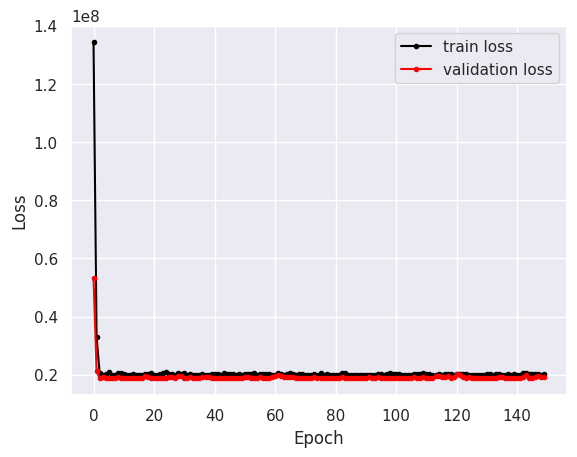

Final train loss: 20098496.0
Final weights: [array([[6473.98]], dtype=float32), array([12849.233], dtype=float32)]
Final validation loss: 19061412.0


In [44]:
# EDIT CODE HERE
model = build_model(num_features=1, learning_rate=0.1)

history = model.fit(
  # use the normalized features prepared above
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

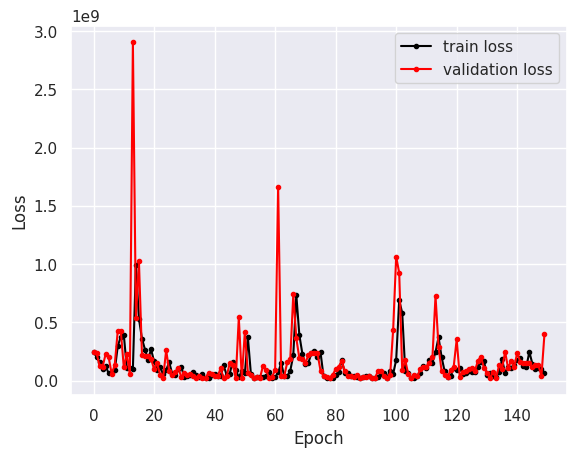

Final train loss: 63983892.0
Final weights: [array([[-6046.5957]], dtype=float32), array([2792.6895], dtype=float32)]
Final validation loss: 399267008.0


In [45]:
# EDIT CODE HERE
model = build_model(num_features=1, learning_rate=1)

history = model.fit(
  # use the normalized features prepared above
  x = car_train_features_norm[['horsepower']],
  y = car_train_labels,
  validation_split=0.1,
  epochs=150,
  batch_size=32,
  verbose=0)

plot_loss(model, history)

*Written answer:* The learning rate 0.01 produces the best validation loss at 18954012.0

---

### Exercise 5: Adding features (20 points)

The goal of this exercise is to compile a table of results -- RMSE computed on the test data for the baseline and 4 models:
1. features = horsepower
2. features = horsepower, peak-rpm
3. features = horsepower, peak-rpm, highway-mpg
4. features = horsepower, peak-rpm, highway-mpg, city-mpg

For consistency, use a batch size of 32, 150 epochs, and the best learning rate you found above.

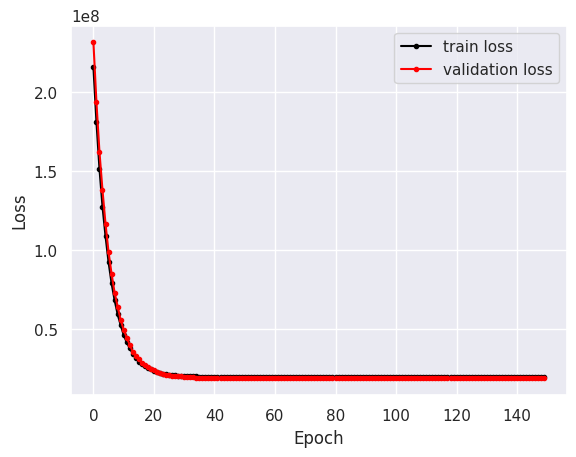

Final train loss: 19829208.0
Final weights: [array([[6535.6763]], dtype=float32), array([13029.8955], dtype=float32)]
Final validation loss: 18954012.0
Test rmse: 5480.311487497768


In [46]:
# features = horsepower
# EDIT CODE HERE
best_learning_rate = 0.01 #add here the learning rate you found above
features = ['horsepower']

def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = car_train_features_norm[features],
    y = car_train_labels,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(car_test_features_norm[features],
                             car_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)

run_experiment(features, best_learning_rate)

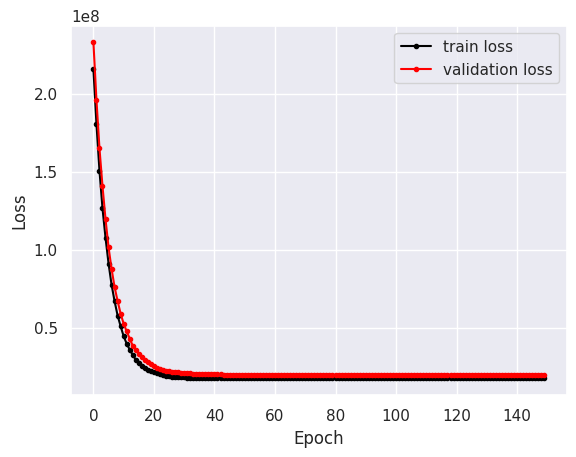

Final train loss: 17721160.0
Final weights: [array([[ 6649.286 ],
       [-1482.6652]], dtype=float32), array([13015.372], dtype=float32)]
Final validation loss: 20008072.0
Test rmse: 5072.518900901208


In [47]:
#features = horsepower, peak-rpm
# EDIT CODE HERE
best_learning_rate = 0.01 #add here the learning rate you found above
features = ['horsepower','peak-rpm']

def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = car_train_features_norm[features],
    y = car_train_labels,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(car_test_features_norm[features],
                             car_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)

run_experiment(features, best_learning_rate)

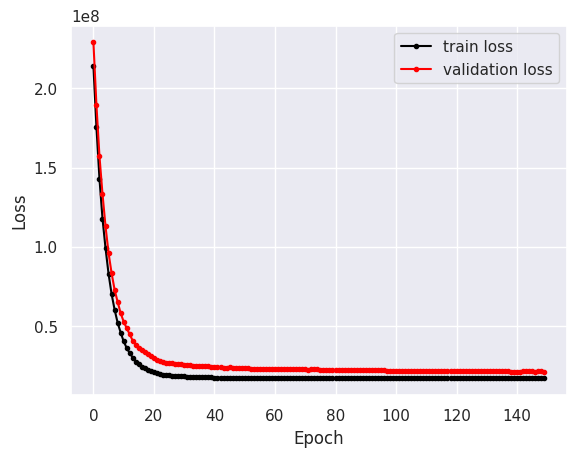

Final train loss: 17297124.0
Final weights: [array([[ 5591.4443],
       [-1507.7006],
       [-1216.8342]], dtype=float32), array([12995.716], dtype=float32)]
Final validation loss: 21562480.0
Test rmse: 4978.610649568814


In [48]:
#features = horsepower, peak-rpm, highway-mpg
# EDIT CODE HERE
best_learning_rate = 0.01 #add here the learning rate you found above
features = ['horsepower','peak-rpm','highway-mpg']

def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = car_train_features_norm[features],
    y = car_train_labels,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(car_test_features_norm[features],
                             car_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)

run_experiment(features, best_learning_rate)

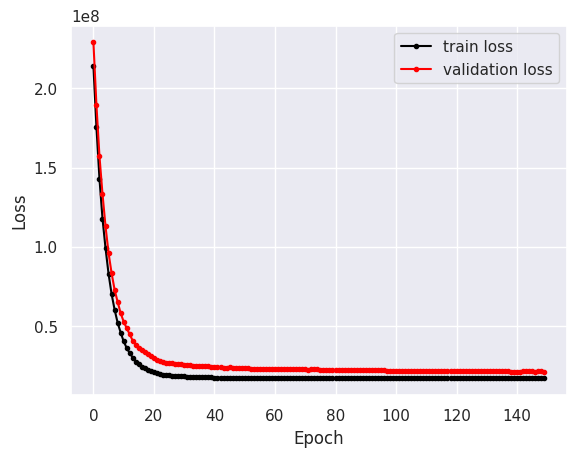

Final train loss: 17297124.0
Final weights: [array([[ 5591.4443],
       [-1507.7006],
       [-1216.8342]], dtype=float32), array([12995.716], dtype=float32)]
Final validation loss: 21562480.0
Test rmse: 4978.610649568814


In [49]:
#features = horsepower, peak-rpm, highway-mpg, city-mpg (all features)
# EDIT CODE HERE
best_learning_rate = 0.01 #add here the learning rate you found above

def run_experiment(features, learning_rate):
  model = build_model(len(features), learning_rate)

  history = model.fit(
    x = car_train_features_norm[features],
    y = car_train_labels,
    validation_split=0.1,
    epochs=150,
    batch_size=32,
    verbose=0)

  plot_loss(model, history)

  # Make predictions on test data
  test_loss = model.evaluate(car_test_features_norm[features],
                             car_test_labels,
                             verbose=0)
  test_rmse = np.sqrt(test_loss)
  print('Test rmse:', test_rmse)

run_experiment(features, best_learning_rate)




*Written answer:*

Model | Test RMSE
--- | ---
Baseline | 8018.00
Horsepower | 5480.31
  + Peak-RPM | 5072.52
  + Highway-MPG | 4978.61
  + City-MPG | 4982.23


---

## Review
* The **[Pandas](https://pandas.pydata.org/) library** is very useful for manipulating datasets and works well with numpy.
* Use a random split into train and test data and measure performance on the test data, starting from a simple **baseline**.
* Examine data using histograms and correlations to help build intuition before training any models.
* **Tensorflow** works by first building a **computational graph**; then, you can pass data through the graph to produce predictions, updating parameters via gradient descent in training mode; we use the **Keras API** to easily configure models.
* Training is often quite sensitive to the **learning rate** hyperparameter, and feature normalization is an important strategy to avoid differences in the scale of the feature derivatives (gradient) that can make learning impossible.